In [100]:
from collections import defaultdict
import math
from textwrap import fill
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  

# Models
from bella.models.target import TargetInd, TargetDepMinus, TargetDep, TargetDepPlus
# Word Vector methods
from bella.word_vectors import VoVectors, SSWE
from bella.helper import read_config
# Sentiment lexicons
from bella import lexicons
# Get the data
from bella.parsers import dong, semeval_14
# Tokenisers
from bella.tokenisers import ark_twokenize, stanford

# Target dependent models
This notebook shows how to use the target dependent models and comparing the results of our implementation to the one in the original [paper](https://www.ijcai.org/Proceedings/15/Papers/194.pdf). We also show the problems we encountered when attempting to reproduce the methods from the description in the paper and the affects of not stating certain processes.

The paper had four different models:
1. **Target-Ind** -- Uses only the full Tweet as context.
2. **Target-Dep-** -- Uses the left and right context of the target word as well as the target word as context.
3. **Target-Dep** -- Uses all of the above contexts.
4. **Target-Dep+** -- Uses all of the above as well as including two additional left and right contexts which ignores all words in the contexts unless they are part of the given sentiment lexicon (or any lexicon).

The above models correspond to the following classes in our implementation:
1. [TargetInd](../tdparse/models/target.py), 2. [TargetDepC](../tdparse/models/target.py), 3. [TargetDep](../tdparse/models/target.py), 4. [TargetDepSent](../tdparse/models/target.py)

All of the results shown below are 5 fold cross validation over the training data of [Dong et al.](https://aclanthology.coli.uni-saarland.de/papers/P14-2009/p14-2009) or where appropriate on the test data as reported in the paper.

In [119]:
##
#  ADD YOUR CONFIG FILE PATH HERE 
##
CONFIG_FP = Path('..', 'config.yaml')

# Load the training data
dong_train = dong(read_config('dong_twit_train_data', CONFIG_FP))
dong_test = dong(read_config('dong_twit_test_data', CONFIG_FP))
train_data = dong_train.data()
test_data = dong_test.data()
train_y = dong_train.sentiment_data()
test_y = dong_test.sentiment_data()

# Get word vectors
# To reduce the number of vectors we load we only load
# the words that are within the train and test set
# which is still as fair in practice as loading the whole
# word vectors
train_words = dong_train.word_list(ark_twokenize)
test_words = dong_test.word_list(ark_twokenize)
all_words = list(set(train_words + test_words))
w2v = VoVectors(filter_words=all_words)
sswe = SSWE(filter_words=all_words)

###
#    Set here the number of cpus to use for all of the
#    grid searching
###

n_cpus = 15

# Comparing the three base models

In the paper the base models (target-ind, target-dep- and target-dep) using the the word2vec word vectors were compared after they found the best C-values therefore we are going to use the C-Values stated in the paper to compare our results to theres. **random_state** is used here to ensure that the results are reproducible, it stops the data from randomly shuffling.

In [3]:
from typing import Tuple, List, Union

def add_row(data: dict, row_name: str, df: pd.DataFrame = pd.DataFrame()) -> pd.DataFrame:
    data_df = pd.DataFrame(data, index=[row_name])
    return pd.concat((df, data_df))

def get_score(grid_scores: pd.DataFrame, 
              associated_param: Union[None, str] = None) -> Union[List[float], List[Tuple[float, str]]]:
    '''
    :param grid_scors: Return of the :py:func:`grid_search_model`
    :param associated_param: Optional. The name of the parameter you want to 
                             associate to the score. E.g. lexicon as you have
                             grid searched over different lexicons and you 
                             want the return to be associated with the 
                             lexicon name e.g. [(0.68, 'MPQA), (0.70, 'NRC')]
    :return: A list of test scores from the grid search and if associated_param
             is not None a list of scores and parameter name.
    '''
    extracted_scores = grid_scores['mean_test_score'].astype(float).round(4) * 100
    extracted_scores = extracted_scores.tolist()
    if associated_param is not None:
        for column in grid_scores.columns:
            if associated_param in column:
                associated_param = column
                break
        else:
            raise Exception(f'Could not find the associated column using {associated_param}')
        associated_param = grid_scores[associated_param].apply(lambda x: str(x)).tolist()
        extracted_scores = list(zip(extracted_scores, associated_param))
    return extracted_scores
    
        

def grid_search_model(model, X, y, **kwargs) -> pd.DataFrame:
    stratified_folds = StratifiedKFold(5)
    # If no kwargs then we grid search over the model
    # parameters already set.
    grid_params = model.get_cv_parameters(**kwargs)
    # model attribute is the sklearn pipeline model that represents
    # the machine learning model
    grid_model = GridSearchCV(model.pipeline(), grid_params, cv=stratified_folds, n_jobs=n_cpus)
    grid_model.fit(X, y)
    grid_results = pd.DataFrame(grid_model.cv_results_)
    return grid_results

In [4]:
# Instances of the models
target_ind = TargetInd([w2v])
target_dep_minus = TargetDepMinus([w2v])
target_dep = TargetDep([w2v])

In [5]:
# Grid search each of the models and compare to paper results
all_results = {}
for model in [target_ind, target_dep_minus, target_dep]:
    all_results[str(model)] = get_score(grid_search_model(model, train_data, train_y, word_vectors=[[w2v]]))

In [6]:
base_results = add_row(all_results, 'Our Results')
base_results = add_row({'Target Dependent': 65.72, 'Target Dependent Minus': 65.38, 
                        'Target Indepdent': 59.22}, 'Paper Results', base_results)
base_results

,Target Dependent,Target Dependent Minus,Target Indepdent
Our Results,66.81,65.67,60.98
Paper Results,65.72,65.38,59.22


As you can see from the results above that we get similar results and the order of the models stays the same.

# Target-Dep+ and sentiment lexicons
The **Target-Dep+** model uses sentiment lexicons to remove words therefore in this section we compare:
1. The statistics on the sentiment lexicons
2. The results of the model using different lexicons

All the experiments below again use the Word2Vec word embeddings.
## Sentiment lexicon statistics

Below we present the size of the sentiment lexicon once it has been processed and the size of that lexicon stated in the paper.

In [7]:
# Load the sentiment lexicons and remove all words that are not associated
# to the Positive or Negative class.

lexicon_data = read_config('lexicons', CONFIG_FP)
hu_liu_fp = Path(lexicon_data['hu_liu'])
mpqa_fp = Path(lexicon_data['mpqa'])
nrc_fp = Path(lexicon_data['nrc_emotion'])

subset_cats = {'positive', 'negative'}
mpqa = lexicons.Mpqa(mpqa_fp, subset_cats=subset_cats)
nrc = lexicons.NRC(nrc_fp, subset_cats=subset_cats)
hu_liu = lexicons.HuLiu(hu_liu_fp, subset_cats=subset_cats)
# Combine sentiment lexicons - Removes words that contradict each other.
mpqa_huliu = lexicons.Lexicon.combine_lexicons(mpqa, hu_liu)
all_three = lexicons.Lexicon.combine_lexicons(mpqa_huliu, nrc)

# Load the sentiment lexicons but lower case all the words
mpqa_low = lexicons.Mpqa(mpqa_fp, subset_cats=subset_cats, lower=True)
nrc_low = lexicons.NRC(nrc_fp, subset_cats=subset_cats, lower=True)
hu_liu_low = lexicons.HuLiu(hu_liu_fp, subset_cats=subset_cats, lower=True)
mpqa_huliu_low = lexicons.Lexicon.combine_lexicons(mpqa_low, hu_liu_low)
all_three_low = lexicons.Lexicon.combine_lexicons(mpqa_huliu_low, nrc_low)

In [8]:
def filter_cat(lexicon, filter_cat):
    return [word for word, cat in lexicon.lexicon if cat == filter_cat]

all_lexicons = [mpqa, hu_liu, nrc, mpqa_huliu, all_three]
num_positive = [len(filter_cat(lexicon, 'positive')) for lexicon in all_lexicons]
num_negative = [len(filter_cat(lexicon, 'negative')) for lexicon in all_lexicons]

all_lexicons_low = [mpqa_low, hu_liu_low, nrc_low, mpqa_huliu_low, all_three_low]
num_positive_low = [len(filter_cat(lexicon, 'positive')) for lexicon in all_lexicons_low]
num_negative_low = [len(filter_cat(lexicon, 'negative')) for lexicon in all_lexicons_low]

columns = ['Paper No. Positive', 'Ours No. Positive', 'Ours low No. Positive', 
           'Paper No. Negative', 'Ours No. Negative', 'Ours low No. Negative']
index = ['MPQA', 'Hu Liu', 'NRC', 'MPQA & Hu Liu', 'All Three']
data = [[2289, 2003, 2231, 2706, 3940], num_positive, num_positive_low, 
        [4114, 4780, 3243, 5069, 6490], num_negative, num_negative_low]
senti_info = dict(list(zip(columns, data)))
pd.DataFrame(senti_info, columns=columns, index=index)

,Paper No. Positive,Ours No. Positive,Ours low No. Positive,Paper No. Negative,Ours No. Negative,Ours low No. Negative
MPQA,2289,2298,2298,4114,4148,4148
Hu Liu,2003,2003,2003,4780,4780,4780
NRC,2231,2231,2231,3243,3243,3243
MPQA & Hu Liu,2706,2725,2725,5069,5080,5076
All Three,3940,4016,4016,6490,6530,6526


In [9]:
# Words that are shared between the MPQA and Hu Liu sentiment lexicons
[word for word, cat in list(set(mpqa_huliu.lexicon).difference(set(mpqa_huliu_low.lexicon))) if cat == 'negative']

['anti-Israeli', 'anti-US', 'anti-American', 'anti-Semites']

As you can see we never agree on the number of words within the lexicons. We get the lexicons from the sources described in the paper. Intrestingly if we do not lower case the words in the lexicons we won't see the same similarities between the MPQA and Hu Liu sentiment lexicon as they both share the words above just the Hu Liu lexicon has the words lower cased already where as MPQA has not.

## Showing the affect of using different sentiment lexicons in the Target-Dep+ model

In [10]:
# Instances of the model
target_dep_plus = TargetDepPlus([w2v], hu_liu_low)

In [11]:
senti_scores = grid_search_model(target_dep_plus, train_data, train_y, 
                                 word_vectors=[[w2v]], senti_lexicon=all_lexicons_low)
senti_scores = get_score(senti_scores, 'lexicon')
senti_scores = {f'Target Dependent Plus {name}': score for score, name in senti_scores}
senti_scores['Target Dependent'] = all_results['Target Dependent']

In [12]:
senti_results = add_row(senti_scores, 'Our Results')
paper_results = [('NRC', 66.05), ('HuLiu', 67.24), ('Mpqa', 65.56), 
                 ('Mpqa HuLiu', 67.40), ('Mpqa HuLiu NRC', 67.30)]
paper_results = {f'Target Dependent Plus {name}': score for name, score in paper_results}
paper_results['Target Dependent'] = 65.72
senti_results = add_row(paper_results, 'Paper Results', senti_results)
senti_results

,Target Dependent,Target Dependent Plus HuLiu,Target Dependent Plus Mpqa,Target Dependent Plus Mpqa HuLiu,Target Dependent Plus Mpqa HuLiu NRC,Target Dependent Plus NRC
Our Results,66.81,68.61,66.81,68.37,68.23,67.13
Paper Results,65.72,67.24,65.56,67.40,67.30,66.05


From the results shown above we get different results but the results also have a different rank between the lexicons as in the best lexicon was **Hu and Liu** where as the papers original results show the combination of **MPQA and Hu & Liu** was the best. However in general we can see that it is better to use a sentiment lexicon than not. Also that both our implmentation and the original paper show that the best single sentiment lexicon is **Hu & Liu** and that using **all three** sentiment lexicons is worse than using **MPQA and Hu & Liu**.

# Showing the affect of the different word vectors
As presented in the paper they show the affect of using different word vectors accross the four models using the best sentiment lexicon for the sentiment dependent model. As we had different result for the sentiment lexicons compared to the original paper we will show the results of using **Hu & Liu** lexicon and using the combination of **Hu & Liu and MPQA**. The word vectors used are the following:
1. Word2Vec - Which has been used throughout the previous experiments (100 dimensions)
2. SSWE - Sentiment Specific Word Embeddings (50 dimensions)
3. Concatenation of Word2vec and SSWE (150 dimensions)

In [13]:
vectors = [[w2v], [sswe], [w2v, sswe]]
vector_results = {}
# Non Sentiment lexicon models
for model in [target_ind, target_dep_minus, target_dep]:
    vector_result = grid_search_model(model, train_data, train_y, word_vectors=vectors)
    vector_result = get_score(vector_result, 'vector')
    vector_results[str(model)] = vector_result
# Sentiment lexicon model, requires a lexicon when grid searching
for model, lexicon in [(target_dep_plus, hu_liu_low), (target_dep_plus, mpqa_huliu_low)]:
    vector_result = grid_search_model(model, train_data, train_y, 
                                      word_vectors=vectors, senti_lexicon=[lexicon])
    vector_result = get_score(vector_result, 'vector')
    vector_results[f'{str(model)} {str(lexicon)}'] = vector_result

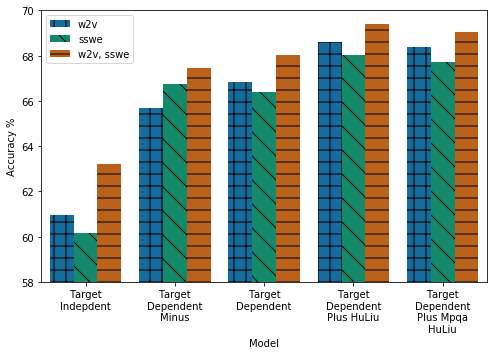

In [55]:
model_score_vectors = [(fill(model,10), score, vectors.strip('[]')) for model, score_vectors in vector_results.items() 
                       for score, vectors in score_vectors]
vector_graph = defaultdict(list)
for model_name, score, vectors in model_score_vectors:
    vector_graph['Model'].append(model_name)
    vector_graph['Accuracy %'].append(score)
    vector_graph['Word Vector(s)'].append(vectors)
ax = sns.barplot(x="Model", y="Accuracy %", hue="Word Vector(s)", 
                 data=pd.DataFrame(vector_graph), palette=sns.color_palette("colorblind"))
# Sets the hatching
hatches = ['+', '\\', '-']
hatch_num = 0
for i in range(len(model_score_vectors)):
    ax.patches[i].set_hatch(hatches[hatch_num])
    if ((i + 1) % 5) == 0:
        hatch_num += 1
ax.set(ylim=(58, 70))
ax.figure.set_size_inches(8,5)
ax.legend()

As we can see from the results above using the combination of the two word vectors is best accross all models which is the finding in the original paper. Also that **Target-Dep+** > **Target-Dep** > **Target-Dep-** > **Target-Ind** which is also what the original paper found. However un-like the original paper we found that using the *SSWE* word vectors to be generally worse than using the *Word2Vec* vectors showing that using just semantic information is more important than using a vector model that was created by reducing the semantic and sentiment loss. Also we found that using **Hu & Liu** lexicon to be better than any other and any other combination of lexicons compared to the original paper which found using the combination of **MPQA and Hu & Liu** to be the best. Finally we can see that we got similar results to the original.

# Results of the final models on the test data
Here we show the affect of the **Target-Ind**, **Target-Dep**, and **Target-Dep+** models on the test data as reported in the paper where each model uses the best parameters found in the previous tests.

For the **Target-Dep+** we show using **Hu & Liu** lexicon and using the combination of **MPQA and Hu & Liu** for direct comparison with the original paper as they found using **MPQA and Hu & Liu** to be better than **Hu & Liu** however we did not.

In [64]:
# Change the default model parameters to use a combination of word 2 vec and SSWE
# vectors
for model in [target_ind, target_dep, target_dep_minus]:
        model.model_parameters = {'word_vectors': [w2v, sswe]}
# Create two new sentiment model version: 1. using Hu Liu 2. using MPQA and Hu Liu
target_sent_hu = TargetDepPlus(word_vectors=[w2v, sswe], senti_lexicon=hu_liu_low)
target_sent_mphu = TargetDepPlus(word_vectors=[w2v, sswe], senti_lexicon=mpqa_huliu_low)

In [69]:
# Fit and predict with the models
test_acc = {}
test_f1 = {}
for model in [target_ind, target_dep, target_dep_minus, target_sent_hu, target_sent_mphu]:
    model.fit(train_data, train_y)
    predictions = model.predict(test_data)
    if model == target_sent_hu:
        model_name = f'{str(model)} Hu Liu'
    elif model == target_sent_mphu:
        model_name = f'{str(model)} MPQA Hu Liu'
    else:
        model_name = f'{str(model)}'
    test_acc[model_name] = round(accuracy_score(test_y, predictions) * 100, 4)
    test_f1[model_name] = round(f1_score(test_y, predictions, average='macro') * 100, 4)

In [74]:
test_results = add_row(test_acc, 'Our Test Accuracy')
paper_acc = {'Target Dependent': 69.7, 'Target Indepdent': 67.3, 'Target Dependent Plus MPQA Hu Liu': 71.1}
test_results = add_row(paper_acc, 'Paper Test Accuracy', test_results)
test_results = add_row(test_f1, 'Our Test Macro F1', test_results)
paper_f1 = {'Target Dependent': 68.0, 'Target Indepdent': 66.4, 'Target Dependent Plus MPQA Hu Liu': 69.9}
test_results = add_row(paper_f1, 'Paper Test Macro F1', test_results)
test_results.astype(float).round(2)

,Target Dependent,Target Dependent Minus,Target Dependent Plus Hu Liu,Target Dependent Plus MPQA Hu Liu,Target Indepdent
Our Test Accuracy,69.65,69.36,70.81,69.94,66.04
Paper Test Accuracy,69.70,NaN,NaN,71.10,67.30
Our Test Macro F1,66.69,66.53,68.68,67.58,61.95
Paper Test Macro F1,68.00,NaN,NaN,69.90,66.40


As you can see from above our results are very close to those reported in the paper and are identical for **Target-Dep** model. Also as you can see that our results using the **Hu Liu** lexicon are much better and are closer to the results of **Target-Dep+** in the original paper 

# Fine Tuning
We want to see if instead of using the C-Value reported in the paper, we fine tune our-seleves the C-Value where we use the combination of **Word2Vec** and **SSWE** embeddings which was never done/shown in the paper to see if we get values closer to those reported in the paper. We only do this for the best model (**Target-Dep+ (Hu Liu)**)

The C-Values to be selected from range from $2^{-15}$ to $2^1$ these values were chosen due to the suggestion in the Lib Linear SVM [guide](https://csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf), we also include the C value 1 as it is the default value for the SKlearn C value.

In [103]:
c_values = [1] # include the default sklearn C Value
for c in range(-15, 3, 2):
    c_values.append(math.pow(2, c))
fine_values = grid_search_model(target_dep_plus, train_data, train_y, 
                                word_vectors=[[w2v, sswe]], senti_lexicon=[hu_liu_low], C=c_values)
best_c = sorted(get_score(fine_values, 'C'), key=lambda x: x[0])[-1][1] 
best_c

In [120]:
target_dep_plus = TargetDepPlus(word_vectors=[w2v, sswe], senti_lexicon=hu_liu_low, C=float(best_c))
target_dep_plus.fit(train_data, train_y)
fine_predictions = target_dep_plus.predict(test_data)
model_name = f'{str(target_dep_plus)} Hu Liu'
fine_acc = {model_name: accuracy_score(test_y, fine_predictions) * 100}
fine_f1 = {model_name: f1_score(test_y, fine_predictions, average='macro') * 100}

In [132]:
fine_tune_results = add_row(fine_acc, 'Tunned Result Accuracy')
fine_tune_results = add_row({model_name: test_acc[model_name]}, 'Our Result Accuracy', fine_tune_results)
fine_tune_results = add_row(fine_f1, 'Tunned Result F1', fine_tune_results)
fine_tune_results = add_row({model_name: test_f1[model_name]}, 'Our Result F1', fine_tune_results)
fine_tune_results

,Target Dependent Plus Hu Liu
Tunned Result Accuracy,0.709538
Our Result Accuracy,70.809200
Tunned Result F1,0.687001
Our Result F1,68.681900


As you can see there is slight improvement but only marginal showing that optimising for different word vectors is not required. This mainly shows that there is probably no correlation between different word vectors and the C value.

# Problems encountered when reproducing results
When reproducing these methods the main error we came across was not **scaling/normalising** the features before inputting them into the SVM classifier.

This was not stated in the paper. We show the affects of not doing this to the results accross all of the different models:

In [75]:
# Change the default model parameters to use a combination of word 2 vec and SSWE
# vectors
for model in [target_ind, target_dep, target_dep_minus]:
        model.model_parameters = {'word_vectors': [w2v, sswe], 'scale': None}
# Create two new sentiment model version: 1. using Hu Liu 2. using MPQA and Hu Liu
target_sent_hu = TargetDepPlus(word_vectors=[w2v, sswe], senti_lexicon=hu_liu_low, scale=None)
target_sent_mphu = TargetDepPlus(word_vectors=[w2v, sswe], senti_lexicon=mpqa_huliu_low, scale=None)

scale_f1 = {}
scale_acc = {}
for model in [target_ind, target_dep, target_dep_minus, target_sent_hu, target_sent_mphu]:
    model.fit(train_data, train_y)
    predictions = model.predict(test_data)
    if model == target_sent_hu:
        model_name = f'{str(model)} Hu Liu'
    elif model == target_sent_mphu:
        model_name = f'{str(model)} MPQA Hu Liu'
    else:
        model_name = f'{str(model)}'
    scale_acc[model_name] = round(accuracy_score(test_y, predictions) * 100, 4)
    scale_f1[model_name] = round(f1_score(test_y, predictions, average='macro') * 100, 4)

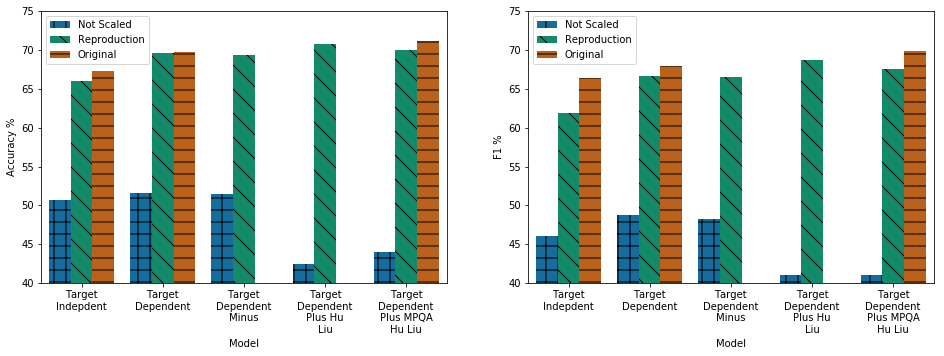

In [131]:
f, axes = plt.subplots(1, 2)
acc_data = (scale_acc, test_acc, paper_acc, 'Accuracy %')
f1_data = (scale_f1, test_f1, paper_f1, 'F1 %')
for i, data in enumerate([acc_data, f1_data]):
    scale_score, test_score, paper_score, score_name = data
    legend_data = [('Not Scaled', scale_score), ('Reproduction', test_score), ('Original', paper_score)]
    scale_model_score = [(scale, fill(model,10), score) for scale, model_score in legend_data 
                         for model, score in model_score.items()]
    scale_graph = defaultdict(list)
    for scale, model, score in scale_model_score:
        scale_graph['Scale'].append(scale)
        scale_graph['Model'].append(model)
        scale_graph[score_name].append(score)
    ax = sns.barplot(x="Model", y=score_name, hue="Scale", 
                     data=pd.DataFrame(scale_graph), 
                     palette=sns.color_palette("colorblind"),
                     ax=axes[i])
    # Sets the hatching
    hatches = ['+', '\\', '-']
    hatch_num = 0
    for i in range(15):
        ax.patches[i].set_hatch(hatches[hatch_num])
        if ((i + 1) % 5) == 0:
            hatch_num += 1
    ax.set(ylim=(40, 75))
    ax.figure.set_size_inches(16,5)
    ax.legend()

As you can see not scaling the data (in this can we used [MinMax](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) scaling) affects the results quite a lot more so for the models that contain more parameters. This was not stated in the paper. They did use a different Support Vector Machine Library [LibLinear](https://www.csie.ntu.edu.tw/~cjlin/liblinear/) however we actually use this library just using the [Scikit-learn interface](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html). Even though in the [Practical guide to LibLinear](https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf) it states that you should scale and shows the importance like we have done above but this is not stated or reiterated in the paper.

This scaling effect can also be seen in the TDParse models of which that notebook can be found [here](./target_model.ipynb)